### 머신러닝(XGBoost)기반 미국프로야구(MLB)의 투구별 출루 및 아웃 예측 모델 개발

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/content/drive/MyDrive/2021-2022_mlb_rawdata.csv')

In [4]:
data.shape

(421879, 92)

In [5]:
data['events'].isnull().sum()

0

In [6]:
data['events']

0         field_out
1         field_out
2            single
3              walk
4         strikeout
            ...    
421874    strikeout
421875    strikeout
421876    field_out
421877    strikeout
421878    field_out
Name: events, Length: 421879, dtype: object

In [7]:
null_counts = data.isnull().sum()
columns_to_drop = null_counts[null_counts > 300].index
data.drop(columns=columns_to_drop, inplace=True)
print("Dropped columns:")
print(columns_to_drop)

Dropped columns:
Index(['spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated',
       'break_length_deprecated', 'hit_location', 'bb_type', 'on_3b', 'on_2b',
       'on_1b', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
       'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle',
       'release_spin_rate', 'release_extension',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_denom', 'launch_speed_angle', 'if_fielding_alignment',
       'of_fielding_alignment', 'spin_axis'],
      dtype='object')


In [8]:
data= data.drop(['game_date', 'player_name', 'batter', 'des',
          'pitcher', 'game_type','home_team', 'away_team', 'game_year',
           'game_pk', 'pitcher', 'fielder_2', 'fielder_3', 'fielder_4',
           'fielder_5','fielder_6','fielder_7','fielder_8','fielder_9'], axis=1)

In [9]:
mapping = {
    'single': 1, 'double': 1, 'triple': 1, 'home_run': 1, 'walk': 1, 'hit_by_pitch': 1,
    'field_out': 0, 'strikeout': 0, 'force_out': 0, 'grounded_into_double_play': 0,
    'double_play': 0, 'fielders_choice': 0, 'strikeout_double_play': 0,
    'fielders_choice_out': 0, 'triple_play': 0
}

data['events'] = data['events'].replace(mapping)

## 중요 변수 추출

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.isnull().sum()

pitch_type            192
release_speed         209
release_pos_x         259
release_pos_z         259
events                  0
description             0
zone                  203
stand                   0
p_throws                0
type                    0
balls                   0
strikes                 0
pfx_x                 210
pfx_z                 205
plate_x               203
plate_z               203
outs_when_up            0
inning                  0
inning_topbot           0
vx0                   203
vy0                   203
vz0                   203
ax                    203
ay                    203
az                    203
sz_top                203
sz_bot                203
effective_speed       256
pitcher.1               0
fielder_2.1             0
release_pos_y         259
woba_value              0
babip_value             0
iso_value               0
at_bat_number           0
pitch_number            0
pitch_name            192
home_score              0
away_score  

In [11]:
data.dropna(inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421534 entries, 0 to 421878
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pitch_type          421534 non-null  object 
 1   release_speed       421534 non-null  float64
 2   release_pos_x       421534 non-null  float64
 3   release_pos_z       421534 non-null  float64
 4   events              421534 non-null  int64  
 5   description         421534 non-null  object 
 6   zone                421534 non-null  float64
 7   stand               421534 non-null  object 
 8   p_throws            421534 non-null  object 
 9   type                421534 non-null  object 
 10  balls               421534 non-null  int64  
 11  strikes             421534 non-null  int64  
 12  pfx_x               421534 non-null  float64
 13  pfx_z               421534 non-null  float64
 14  plate_x             421534 non-null  float64
 15  plate_z             421534 non-nul

In [13]:
data.drop(data[data['pitch_type'] == 'FA'].index, inplace=True)
mapping = {
    'FF': 1, 'SI': 1, 'FC': 1,
    'SL': 2, 'KC': 2, 'CU': 2, 'CS': 2, 'KN': 2, 'EP': 2, 'SV': 2, 'ST': 2,
    'FS': 3, 'CH': 3, 'SC': 3
}

data['pitch_type'] = data['pitch_type'].replace(mapping)

In [14]:
data = pd.get_dummies(data, columns=['pitch_type'], prefix='pitch')
data = pd.get_dummies(data, columns=['description'], prefix='description')
data = pd.get_dummies(data, columns=['type'], prefix='type')
data = pd.get_dummies(data, columns=['pitch_name'], prefix='pitch_name')
data = pd.get_dummies(data, columns=['inning_topbot'], prefix='inning_topbot')
data = pd.get_dummies(data, columns=['stand'], prefix='stand')
data = pd.get_dummies(data, columns=['p_throws'], prefix='p_throws')

In [15]:
data = data.replace({False: 0, True: 1})
data.head(5)

,release_speed,release_pos_x,release_pos_z,events,zone,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,pitcher.1,fielder_2.1,release_pos_y,woba_value,babip_value,iso_value,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,delta_home_win_exp,delta_run_exp,pitch_1,pitch_2,pitch_3,description_ball,description_blocked_ball,description_bunt_foul_tip,description_called_strike,description_foul_bunt,description_foul_tip,description_hit_by_pitch,description_hit_into_play,description_missed_bunt,description_swinging_strike,description_swinging_strike_blocked,type_B,type_S,type_X,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Eephus,pitch_name_Knuckle Curve,pitch_name_Knuckleball,pitch_name_Screwball,pitch_name_Sinker,pitch_name_Slider,pitch_name_Slow Curve,pitch_name_Slurve,pitch_name_Split-Finger,pitch_name_Sweeper,inning_topbot_Bot,inning_topbot_Top,stand_L,stand_R,p_throws_L,p_throws_R
0,84.6,-2.20,6.49,0,9.0,0,2,0.47,0.25,0.60,1.68,2,5,5.662031,-123.150074,-5.457570,3.733274,23.195655,-28.744663,3.42,1.66,85.5,601713,608700,53.74,0.0,0,0,45,3,1,3,1,3,3,1,1,3,-0.060,-0.275,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
1,84.7,-2.33,6.41,0,8.0,0,0,0.78,0.10,0.09,1.79,1,5,4.107405,-123.239942,-4.671884,7.152201,24.011905,-30.468382,3.58,1.76,85.4,601713,608700,53.78,0.0,0,0,44,1,1,3,1,3,3,1,1,3,-0.064,-0.464,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
2,91.7,-2.13,6.48,1,1.0,2,1,-0.63,1.57,-0.80,2.69,1,5,4.790940,-133.433602,-7.215444,-8.587217,27.139350,-12.003441,3.18,1.51,92.9,601713,608700,53.61,0.9,1,0,43,4,1,3,1,3,3,1,1,3,0.053,0.479,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
3,90.6,-2.28,6.33,1,14.0,3,1,-0.75,1.45,0.84,2.07,1,5,9.395170,-131.357045,-7.774516,-10.669152,28.733451,-13.878226,3.15,1.45,90.7,601713,608700,53.88,0.7,0,0,42,5,1,3,1,3,3,1,1,3,0.036,0.168,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
4,84.4,-1.93,6.52,0,14.0,2,2,0.56,-0.09,0.51,1.20,0,5,4.596731,-122.790400,-5.858114,4.805528,24.308376,-32.133148,3.34,1.62,85.1,601713,608700,53.76,0.0,0,0,41,5,1,3,1,3,3,1,1,3,-0.031,-0.216,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1


In [16]:
data.shape

(420807, 77)

In [17]:
#description, type, bb_type, hit_location, pitch_type, balls, strikes,
#launch_speed, launch_angle, inning, outs_when_up, inning_topbot,
#if_fielding_allingment, of_fielding_allingment

Correlation

In [18]:
correlation_matrix = data.corr()

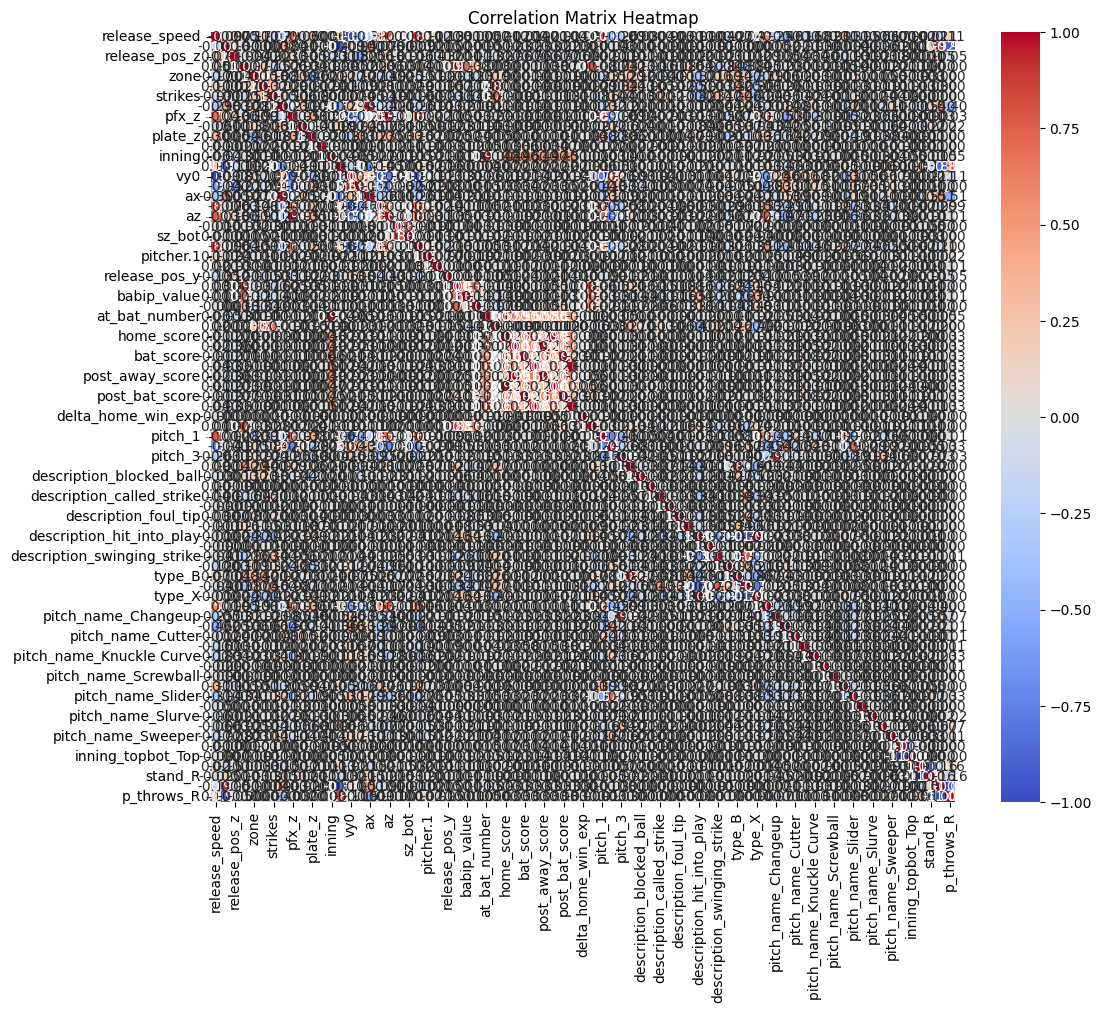

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
top_correlations = correlation_matrix.unstack().sort_values(ascending=False, key=abs).drop_duplicates()
top_correlations = top_correlations[1:101]  # Exclude self-correlations and limit to top 20
top_correlations_df = pd.DataFrame(top_correlations, columns=['Correlation'])
top_correlations_df['Absolute Correlation'] = top_correlations_df['Correlation'].abs()
top_correlations_df

,,Correlation,Absolute Correlation
release_speed,release_speed,1.000000,1.000000
stand_L,stand_R,-1.000000,1.000000
p_throws_L,p_throws_R,-1.000000,1.000000
description_hit_into_play,type_X,0.999978,0.999978
vy0,release_speed,-0.999810,0.999810
post_away_score,away_score,0.993841,0.993841
home_score,post_home_score,0.993340,0.993340
bat_score,post_bat_score,0.987275,0.987275
az,pfx_z,0.985918,0.985918
pfx_x,ax,0.982245,0.982245


In [21]:
correlation_with_target = data.corrwith(data['events'])
top = correlation_with_target.abs().nlargest(50)
top_correlations_df = pd.DataFrame({'Correlation': correlation_with_target[top.index],
                                   'Absolute Correlation': top})
top_correlations_df

,Correlation,Absolute Correlation
events,1.000000,1.000000
woba_value,0.905435,0.905435
delta_run_exp,0.779763,0.779763
babip_value,0.710130,0.710130
type_B,0.476856,0.476856
description_ball,0.421499,0.421499
iso_value,0.378931,0.378931
type_S,-0.376694,0.376694
description_swinging_strike,-0.281714,0.281714
balls,0.166252,0.166252


In [22]:
data.shape

(420807, 77)

Univariate Testing - statistical tests to find relationships between the output variable and each input variable in isolation.

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression

In [24]:
X = data.drop(["events"], axis = 1)
y = data["events"]

In [25]:
feature_selector = SelectKBest(f_regression, k = "all")
fit = feature_selector.fit(X,y)

In [26]:
p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_variable_names = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "f_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

In [27]:
p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["f_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
X_new = X[selected_variables]

In [28]:
X_new.shape

(420807, 63)

In [ ]:
Y.shape

Recursive Feature Elimination with Cross-Validation (RFECV)
fits a model that starts with all the input variables, then iteratively removes those with the weakest relationship with the output until the desired number of features is reached.

In [29]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [30]:
regressor = LinearRegression()
feature_selector = RFECV(regressor)

In [31]:
feature_selector.fit(X, y)

RFECV(estimator=LinearRegression())

In [32]:

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X.loc[:, feature_selector.get_support()]


Optimal numer of features: 68


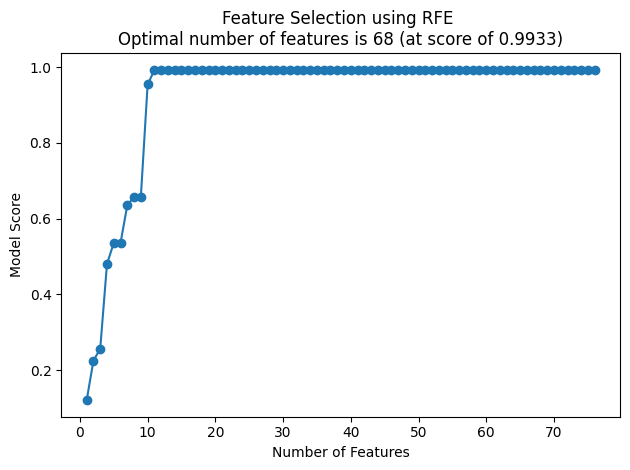

In [33]:
plt.plot(range(1, len(feature_selector.cv_results_['mean_test_score']) + 1), feature_selector.cv_results_['mean_test_score'], marker="o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \nOptimal number of features is {optimal_feature_count} (at score of {round(max(feature_selector.cv_results_['mean_test_score']), 4)})")
plt.tight_layout()
plt.show()

In [34]:
X_new.head(5)

,release_speed,release_pos_x,release_pos_z,zone,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,vx0,vy0,vz0,az,sz_top,sz_bot,release_pos_y,woba_value,babip_value,iso_value,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,delta_home_win_exp,delta_run_exp,pitch_1,pitch_2,pitch_3,description_ball,description_blocked_ball,description_bunt_foul_tip,description_called_strike,description_foul_bunt,description_hit_by_pitch,description_hit_into_play,description_missed_bunt,description_swinging_strike,description_swinging_strike_blocked,type_B,type_S,type_X,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Eephus,pitch_name_Knuckle Curve,pitch_name_Knuckleball,pitch_name_Screwball,pitch_name_Sinker,pitch_name_Slider,pitch_name_Slow Curve,pitch_name_Slurve,pitch_name_Split-Finger,pitch_name_Sweeper,inning_topbot_Bot,inning_topbot_Top,stand_L,stand_R,p_throws_L
0,84.6,-2.20,6.49,9.0,0,2,0.47,0.25,0.60,1.68,2,5,5.662031,-123.150074,-5.457570,-28.744663,3.42,1.66,53.74,0.0,0,0,45,3,1,3,1,3,3,1,1,3,-0.060,-0.275,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,84.7,-2.33,6.41,8.0,0,0,0.78,0.10,0.09,1.79,1,5,4.107405,-123.239942,-4.671884,-30.468382,3.58,1.76,53.78,0.0,0,0,44,1,1,3,1,3,3,1,1,3,-0.064,-0.464,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
2,91.7,-2.13,6.48,1.0,2,1,-0.63,1.57,-0.80,2.69,1,5,4.790940,-133.433602,-7.215444,-12.003441,3.18,1.51,53.61,0.9,1,0,43,4,1,3,1,3,3,1,1,3,0.053,0.479,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,90.6,-2.28,6.33,14.0,3,1,-0.75,1.45,0.84,2.07,1,5,9.395170,-131.357045,-7.774516,-13.878226,3.15,1.45,53.88,0.7,0,0,42,5,1,3,1,3,3,1,1,3,0.036,0.168,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,84.4,-1.93,6.52,14.0,2,2,0.56,-0.09,0.51,1.20,0,5,4.596731,-122.790400,-5.858114,-32.133148,3.34,1.62,53.76,0.0,0,0,41,5,1,3,1,3,3,1,1,3,-0.031,-0.216,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


Random Forest

In [35]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

In [49]:
rfc_cv_score = cross_val_score(rf, X_new, y, cv=3, scoring='roc_auc')

In [50]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[57439     0]
 [    0 26723]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57439
           1       1.00      1.00      1.00     26723

    accuracy                           1.00     84162
   macro avg       1.00      1.00      1.00     84162
weighted avg       1.00      1.00      1.00     84162



=== All AUC Scores ===
[1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


In [40]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78963c7feb00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78963c7fe950>})

In [41]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 368}


In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

LGBM

In [52]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state = 0)
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 93541, number of negative: 201023
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4259
[LightGBM] [Info] Number of data points in the train set: 294564, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.317557 -> initscore=-0.765019
[LightGBM] [Info] Start training from score -0.765019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain